In [1]:

#from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import os
from PIL import Image

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, ResNet101
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras.metrics import AUC

In [2]:

df_helper = pd.read_csv('/Users/dezmon/Library/Mobile Documents/com~apple~CloudDocs/Deep Learning_AI/Final Project/RSNA-256-helper.csv')

df_helper

,patient_id,image_id,laterality,view,age,implant,path,cancer
0,10006,462822612,0,1,61.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
1,10006,1459541791,0,5,61.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
2,10006,1864590858,1,5,61.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
3,10006,1874946579,1,1,61.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
4,10011,220375232,0,1,55.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
...,...,...,...,...,...,...,...,...
54701,9973,1729524723,1,5,43.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
54702,9989,63473691,0,5,60.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
54703,9989,1078943060,0,1,60.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
54704,9989,398038886,1,5,60.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0


In [3]:
# Load the directory containing the images
image_directory = '/Users/dezmon/Library/Mobile Documents/com~apple~CloudDocs/Deep Learning_AI/Final Project/RSNA-516/'

In [4]:
# Initialize lists to store data
image_sizes = []
image_paths = []

In [5]:
# Iterate over each image in the directory
for image_name in os.listdir(image_directory):
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tif', '.tiff')):
        image_path = os.path.join(image_directory, image_name)
        image = Image.open(image_path)
        image_sizes.append(image.size)  # Store image size (width, height)
        image_paths.append(image_path)

# Convert to numpy array for analysis
image_sizes = np.array(image_sizes)

In [6]:
# Construct the image_path column dynamically
df_helper['image_path'] = '/Users/dezmon/Library/Mobile Documents/com~apple~CloudDocs/Deep Learning_AI/Final Project/RSNA-516/' + df_helper['patient_id'].astype(str) + '_' + df_helper['image_id'].astype(str) + '.png'

In [7]:
df = df_helper[['image_path', 'cancer']]

In [8]:
print(df_helper['cancer'].value_counts())

cancer
0    53548
1     1158
Name: count, dtype: int64


<Axes: ylabel='count'>

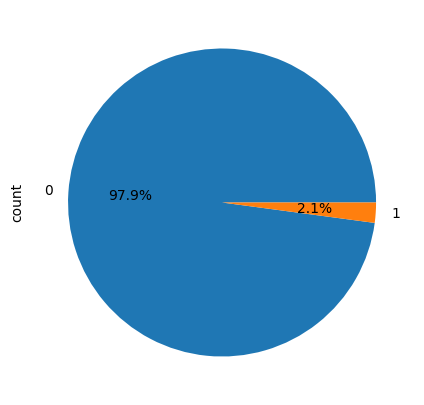

In [9]:
df_helper['cancer'].value_counts().plot.pie(autopct='%.1f%%', figsize=(5, 5))

cancer
1    1158
0    1158
Name: count, dtype: int64


<Axes: ylabel='count'>

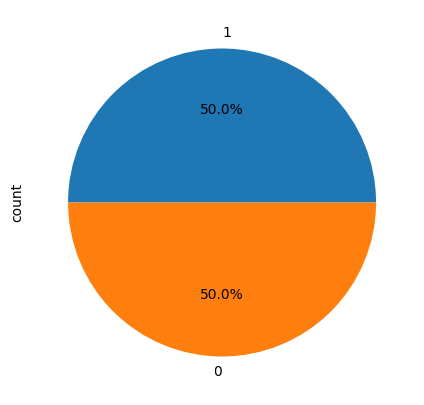

In [10]:
# Get the number of instances with class 1 (cancer)
num_cancer = df['cancer'].value_counts()[1]

# Get the indices of instances with class 1 (cancer)
indexs_cancer = np.array(df[df['cancer'] == 1].index)

# Get the indices of instances with class 0 (not cancer)
indexs_not_cancer = np.array(df[df['cancer'] == 0].index)

# Get indices of instances with class 0 (not cancer) randomly sampled with the same amount as class 1 (cancer)
indexs_not_cancer_balanced = np.random.choice(indexs_not_cancer, num_cancer, replace=False)

# Concatenate indices of instances with class 0 and 1
indexs_balanced = np.concatenate([indexs_cancer, indexs_not_cancer_balanced])

# Create a new dataframe with balanced classes
df_balanced = df.iloc[indexs_balanced, :]

# Check the class distribution after balancing
print(df_balanced['cancer'].value_counts())

# Plot pie chart to visualize the balanced class distribution
df_balanced['cancer'].value_counts().plot.pie(autopct='%.1f%%', figsize=(5, 5))

In [11]:
from matplotlib.image import imread

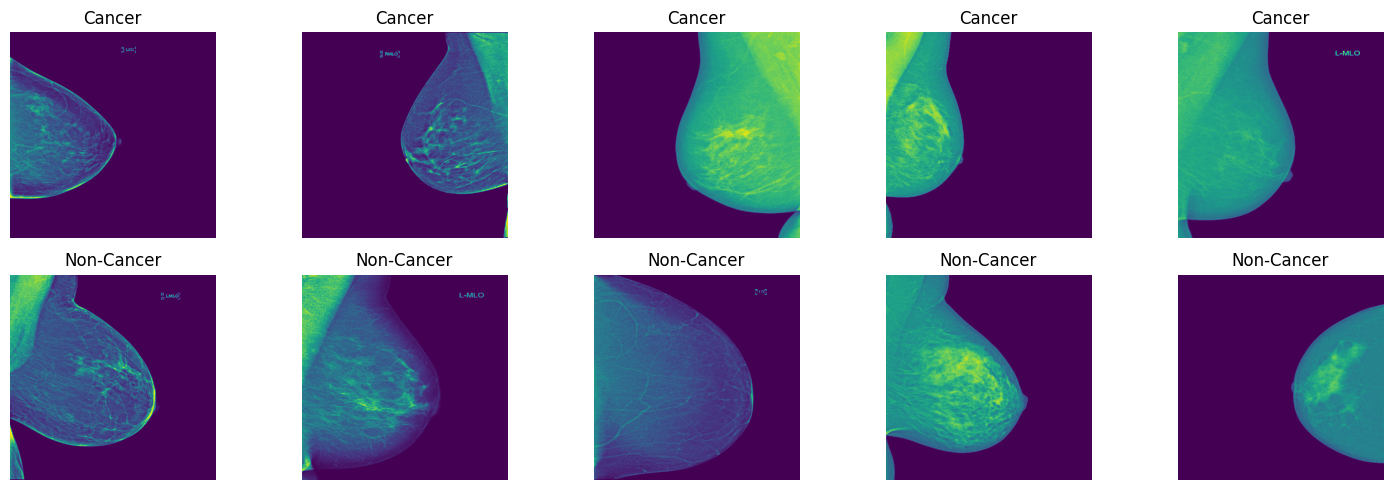

In [12]:
# Filter images based on cancer_label
cancer_images = df_balanced[df_balanced['cancer'] == 1].sample(5)  # Select 5 cancer images randomly
non_cancer_images = df_balanced[df_balanced['cancer'] == 0].sample(5)  # Select 5 non-cancer images randomly

# Plotting cancer images
plt.figure(figsize=(15, 5))
for i, (index, row) in enumerate(cancer_images.iterrows()):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imread(row['image_path']))
    plt.title('Cancer')
    plt.axis('off')

# Plotting non-cancer images
for i, (index, row) in enumerate(non_cancer_images.iterrows()):
    plt.subplot(2, 5, 5 + i + 1)
    plt.imshow(imread(row['image_path']))
    plt.title('Non-Cancer')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
X_train, X_val_test, y_train, y_val_test = train_test_split(df_balanced['image_path'], df_balanced['cancer'], test_size=0.4, random_state=42, stratify = df_balanced['cancer'])
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test)


In [14]:
# Create DataFrames for train, validation, and test sets
train_df = pd.DataFrame({'image_path': X_train, 'cancer': y_train})
val_df = pd.DataFrame({'image_path': X_val, 'cancer': y_val})
test_df = pd.DataFrame({'image_path': X_test, 'cancer': y_test})

# Check class distribution in each set
train_class_distribution = train_df['cancer'].value_counts(normalize=True)
val_class_distribution = val_df['cancer'].value_counts(normalize=True)
test_class_distribution = test_df['cancer'].value_counts(normalize=True)

print("Train Set Class Distribution:")
print(train_class_distribution)
print("\nValidation Set Class Distribution:")
print(val_class_distribution)
print("\nTest Set Class Distribution:")
print(test_class_distribution)

Train Set Class Distribution:
cancer
1    0.50036
0    0.49964
Name: proportion, dtype: float64

Validation Set Class Distribution:
cancer
0    0.50108
1    0.49892
Name: proportion, dtype: float64

Test Set Class Distribution:
cancer
1    0.5
0    0.5
Name: proportion, dtype: float64


In [15]:
# ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #zoom_range=0.4, # Randomly rotate images by up to 40 degrees
    brightness_range = [0.8,1.2], # Randomly adjust brightness between 0.8 and 1.2
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Parameters
batch_size = 32
target_size = (224, 224)  # InceptionNetV3 input size

In [16]:
# Flow from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_train, 'cancer': y_train.astype(str)}),
    x_col='image_path',
    y_col='cancer',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_val, 'cancer': y_val.astype(str)}),
    x_col='image_path',
    y_col='cancer',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_test, 'cancer': y_test.astype(str)}),
    x_col='image_path',
    y_col='cancer',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 1389 validated image filenames belonging to 2 classes.
Found 463 validated image filenames belonging to 2 classes.
Found 464 validated image filenames belonging to 2 classes.


In [17]:
train_generator.class_indices
test_generator.class_indices
val_generator.class_indices

{'0': 0, '1': 1}

In [18]:
def plot_learning(history):
    tgts = ['loss', 'accuracy']
    vtgts = ['val_loss', 'val_accuracy']

    for tgt, val_tgt in zip(tgts, vtgts):
      plt.figure()
      plt.plot(history.history[tgt], label=tgt)
      plt.plot(history.history[val_tgt], label=val_tgt)
      plt.xlabel('Epoch')
      #plt.ylabel(ylab)
      plt.legend()
      plt.title(f"Training and validation {tgt}")

# Resnet50

In [19]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Initial learning rate
initial_learning_rate = 0.1
# Create an optimizer with the initial learning rate
#optimizer = Adam(learning_rate=initial_learning_rate)

Change this part for resnet: input_shape=(224, 224, 3)

In [20]:
def create_model(learning_rate):
    ##inceptionv3_base = InceptionV3(weights='imagenet', include_top=False)
    base_model = ResNet50(weights='imagenet', include_top=False)
# Freeze base layers
    for layer in base_model.layers[:-10]:
      layer.trainable = False

    ##for layer in inceptionv3_base.layers[:-10]:
        ##layer.trainable = False

    #x3 = inceptionv3_base.output
    x3 = base_model.output
    x3 = GlobalAveragePooling2D()(x3)
    x3 = Dense(256, activation='relu')(x3)
    x3 = Dropout(0.5)(x3)
    predictions = Dense(1, activation='sigmoid')(x3)

    #model = Model(inputs=inceptionv3_base.input, outputs=predictions)
    model = Model (inputs = base_model.input, outputs = predictions)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC()])

    return model

In [21]:
#from tensorflow.keras.models import Model
#model.summary()

In [22]:
# Define hyperparameters
learning_rates = [0.001, 0.01]
batch_sizes = [32, 64]
epochs = 10
# Define lists to store models and histories
models_list = []
histories_list = []
hyperparameter_list = []

Change function m=resnet

In [23]:
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training model with learning rate: {lr} and batch size: {batch_size}")
        model = create_model(lr)
        history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

        models_list.append(model)
        histories_list.append(history)

        # Store hyperparameters for each model
        hyperparameters = {'learning_rate': lr, 'batch_size': batch_size}
        hyperparameter_list.append(hyperparameters)



Training model with learning rate: 0.001 and batch size: 32


2024-05-01 17:09:45.299259: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-01 17:09:45.299279: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-01 17:09:45.299283: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-01 17:09:45.299312: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-01 17:09:45.299326: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2024-05-01 17:09:47.911981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:09:48.066063: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


44/44 [==============================] - 25s 532ms/step - loss: 0.9048 - accuracy: 0.4780 - auc: 0.4780 - val_loss: 8.1139 - val_accuracy: 0.4989 - val_auc: 0.5000
Epoch 2/10
44/44 [==============================] - 24s 535ms/step - loss: 0.7748 - accuracy: 0.4896 - auc: 0.4780 - val_loss: 1.5542 - val_accuracy: 0.5011 - val_auc: 0.5408
Epoch 3/10
44/44 [==============================] - 23s 524ms/step - loss: 0.7588 - accuracy: 0.5004 - auc: 0.5053 - val_loss: 5.3009 - val_accuracy: 0.4989 - val_auc: 0.5000
Epoch 4/10
44/44 [==============================] - 24s 540ms/step - loss: 0.7646 - accuracy: 0.5083 - auc: 0.5128 - val_loss: 3.6611 - val_accuracy: 0.5011 - val_auc: 0.5108
Epoch 5/10
44/44 [==============================] - 23s 522ms/step - loss: 0.7594 - accuracy: 0.4989 - auc: 0.5112 - val_loss: 11.1135 - val_accuracy: 0.5011 - val_auc: 0.5000
Training model with learning rate: 0.001 and batch size: 64


Epoch 1/10


2024-05-01 17:11:48.394679: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


44/44 [==============================] - 24s 507ms/step - loss: 0.9354 - accuracy: 0.4413 - auc_1: 0.4472 - val_loss: 10.3458 - val_accuracy: 0.5011 - val_auc_1: 0.5000
Epoch 2/10
44/44 [==============================] - 21s 474ms/step - loss: 0.7683 - accuracy: 0.4917 - auc_1: 0.4915 - val_loss: 0.7501 - val_accuracy: 0.5011 - val_auc_1: 0.5304
Epoch 3/10
44/44 [==============================] - 24s 543ms/step - loss: 0.7552 - accuracy: 0.4953 - auc_1: 0.4991 - val_loss: 1.1126 - val_accuracy: 0.5011 - val_auc_1: 0.5448
Epoch 4/10
44/44 [==============================] - 24s 540ms/step - loss: 0.7198 - accuracy: 0.5212 - auc_1: 0.5287 - val_loss: 0.7267 - val_accuracy: 0.5011 - val_auc_1: 0.5599
Epoch 5/10
44/44 [==============================] - 24s 548ms/step - loss: 0.7177 - accuracy: 0.5299 - auc_1: 0.5274 - val_loss: 0.7467 - val_accuracy: 0.5011 - val_auc_1: 0.5590
Epoch 6/10
44/44 [==============================] - 19s 421ms/step - loss: 0.7180 - accuracy: 0.5212 - auc_1: 0.533

Epoch 1/10


2024-05-01 17:15:14.582400: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


44/44 [==============================] - 28s 573ms/step - loss: 3.2319 - accuracy: 0.4953 - auc_2: 0.5057 - val_loss: 63.3230 - val_accuracy: 0.5011 - val_auc_2: 0.5000
Epoch 2/10
44/44 [==============================] - 23s 527ms/step - loss: 1.0623 - accuracy: 0.5126 - auc_2: 0.5140 - val_loss: 4.0185 - val_accuracy: 0.4989 - val_auc_2: 0.5000
Epoch 3/10
44/44 [==============================] - 24s 534ms/step - loss: 1.1516 - accuracy: 0.4881 - auc_2: 0.4910 - val_loss: 1.7055 - val_accuracy: 0.5011 - val_auc_2: 0.5524
Epoch 4/10
44/44 [==============================] - 24s 547ms/step - loss: 0.8369 - accuracy: 0.5277 - auc_2: 0.5332 - val_loss: 1.7112 - val_accuracy: 0.5011 - val_auc_2: 0.5621
Epoch 5/10
44/44 [==============================] - 23s 529ms/step - loss: 0.8583 - accuracy: 0.4975 - auc_2: 0.5023 - val_loss: 0.8536 - val_accuracy: 0.4989 - val_auc_2: 0.5530
Epoch 6/10
44/44 [==============================] - 19s 434ms/step - loss: 0.9269 - accuracy: 0.5083 - auc_2: 0.518

Epoch 1/10


2024-05-01 17:19:07.166451: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


44/44 [==============================] - 29s 600ms/step - loss: 4.3620 - accuracy: 0.5004 - auc_3: 0.4998 - val_loss: 414.2513 - val_accuracy: 0.4989 - val_auc_3: 0.5000
Epoch 2/10
44/44 [==============================] - 23s 533ms/step - loss: 1.7447 - accuracy: 0.5112 - auc_3: 0.5139 - val_loss: 50.8835 - val_accuracy: 0.4989 - val_auc_3: 0.5000
Epoch 3/10
44/44 [==============================] - 23s 530ms/step - loss: 1.1145 - accuracy: 0.4989 - auc_3: 0.4977 - val_loss: 2.2182 - val_accuracy: 0.4989 - val_auc_3: 0.4670
Epoch 4/10
44/44 [==============================] - 24s 546ms/step - loss: 0.9591 - accuracy: 0.5169 - auc_3: 0.5225 - val_loss: 2.6088 - val_accuracy: 0.4989 - val_auc_3: 0.4355
Epoch 5/10
44/44 [==============================] - 24s 545ms/step - loss: 1.3319 - accuracy: 0.4946 - auc_3: 0.4847 - val_loss: 0.9005 - val_accuracy: 0.5032 - val_auc_3: 0.5823
Epoch 6/10
44/44 [==============================] - 20s 442ms/step - loss: 1.1804 - accuracy: 0.5284 - auc_3: 0.5

In [24]:
best_model = None
best_accuracy = 0.0
best_hyperparameters = None

for model, history, hyperparameters in zip(models_list, histories_list, hyperparameter_list):
    val_accuracy = history.history['val_accuracy'][-1]  # Get the last validation accuracy

    if val_accuracy > best_accuracy:
        best_model = model
        best_accuracy = val_accuracy
        best_hyperparameters = hyperparameters
        best_history = history
inception_model = model.save('/Users/dezmon/Library/Mobile Documents/com~apple~CloudDocs/Deep Learning_AI/Final Project/resnet_model.h5')

In [25]:
# Find the index of the best model
best_model_index = models_list.index(best_model)

# Retrieve the hyperparameters of the best model
best_hyperparameters = hyperparameter_list[best_model_index]
# Print the results
print("Best model hyperparameters:")
print(best_hyperparameters)

Best model hyperparameters:
{'learning_rate': 0.01, 'batch_size': 32}


In [26]:
# Evaluate the best model on the test dataset
test_loss, test_accuracy, test_auc = best_model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test AUC:", test_auc)

15/15 [==============================] - 5s 338ms/step - loss: 0.7050 - accuracy: 0.5194 - auc_2: 0.5542
Test Loss: 0.7049580812454224
Test Accuracy: 0.5193965435028076
Test AUC: 0.5542137622833252


## Model Performance

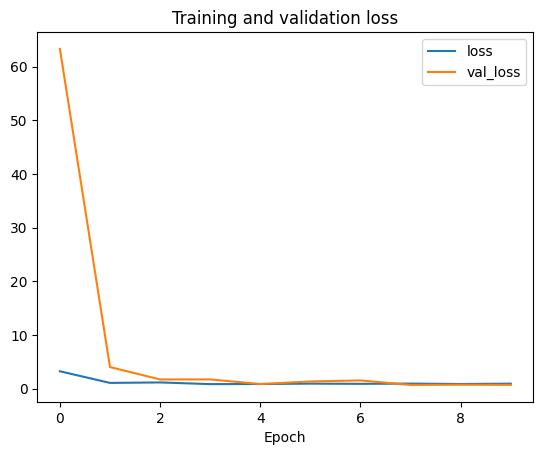

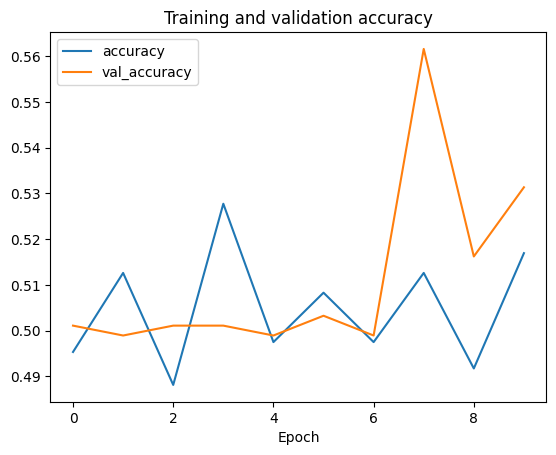

In [27]:

def plot_learning(history):
    tgts = ['loss', 'accuracy']
    vtgts = ['val_loss', 'val_accuracy']

    for tgt, val_tgt in zip(tgts, vtgts):
        plt.figure()
        plt.plot(history.history[tgt], label=tgt)
        plt.plot(history.history[val_tgt], label=val_tgt)
        plt.xlabel('Epoch')
        plt.legend()
        plt.title(f"Training and validation {tgt}")

# Assuming you have found the best model, its corresponding history is stored in best_history
plot_learning(best_history)

In [28]:
# After training, print the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [29]:
from sklearn.metrics import roc_curve, auc
# Get true labels of test data
test_pred1 = best_model.predict(test_generator)
test_true = test_generator.classes
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_true, test_pred1)

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Threshold predictions based on optimal threshold
test_pred_binary1 = (test_pred1 > optimal_threshold).astype(int)

15/15 [==============================] - 6s 320ms/step


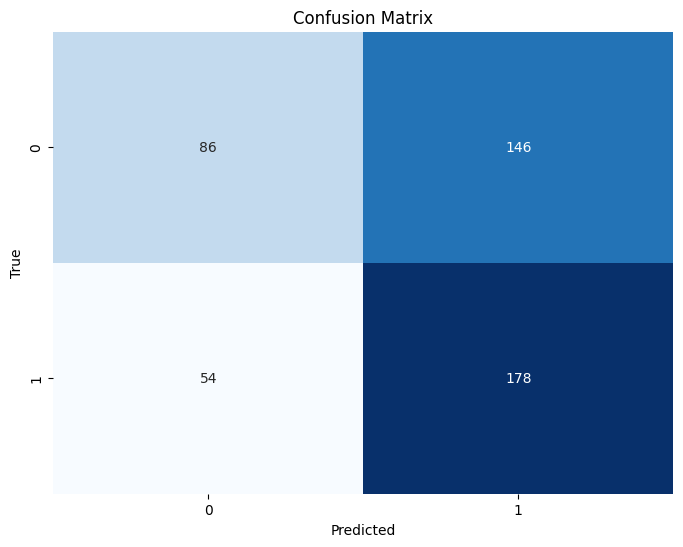

In [30]:
plot_confusion_matrix(test_true, test_pred_binary1)

In [31]:
from sklearn.metrics import classification_report# Generate classification report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [32]:
accuracy = accuracy_score(test_true, test_pred_binary1)
precision = precision_score(test_true, test_pred_binary1)
recall = recall_score(test_true, test_pred_binary1)
f1 = f1_score(test_true, test_pred_binary1)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.5689655172413793
Precision: 0.5493827160493827
Recall: 0.7672413793103449
F1 Score: 0.6402877697841727


In [33]:
#pip install opencv-python

In [34]:
import cv2
def visualize_data(image_data):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (if necessary)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [35]:
# Identify false positive cases
# Identify false positive cases
false_positives = []
for i in range(len(test_true)):
    if test_true[i] == 0 and test_pred_binary1[i] == 1:  # Actual negative, predicted positive
        false_positives.append(i)

# Select around 10 cases for closer examination
selected_false_positives = false_positives[:min(10, len(false_positives))]

selected_false_positives

[1, 7, 8, 9, 10, 11, 13, 17, 19, 20]

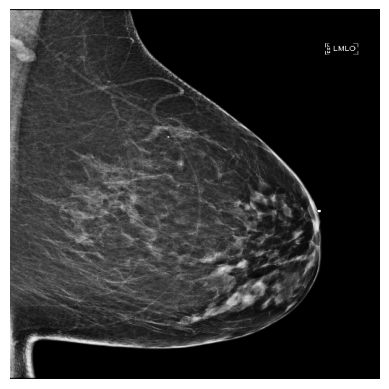

Predicted Probability: [0.67366815]


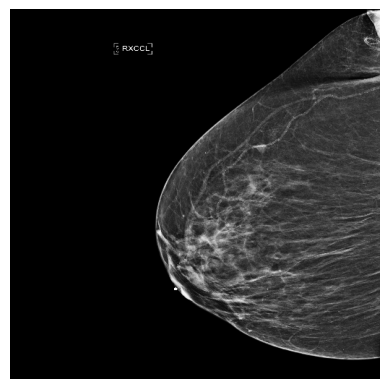

Predicted Probability: [0.6795204]


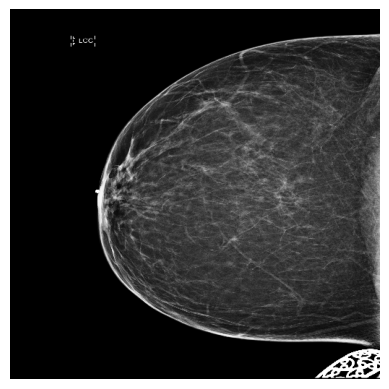

Predicted Probability: [0.6343035]


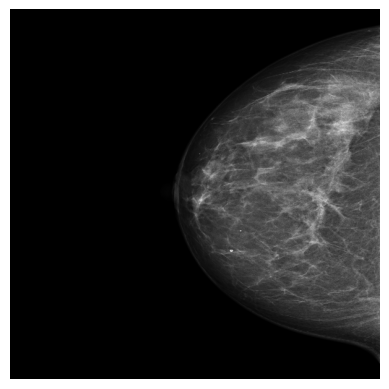

Predicted Probability: [0.5609645]


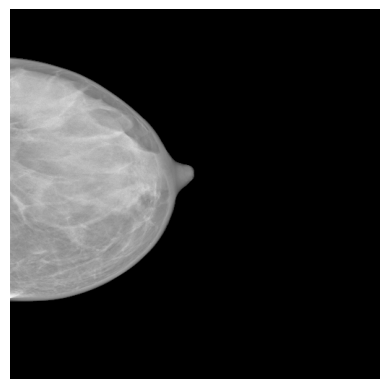

Predicted Probability: [0.58382255]


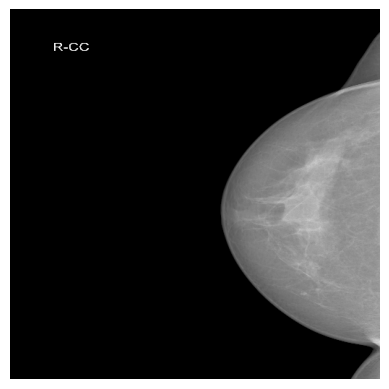

Predicted Probability: [0.57031024]


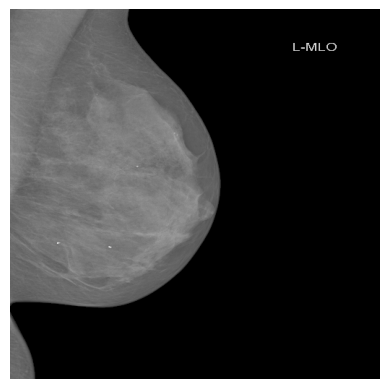

Predicted Probability: [0.5630002]


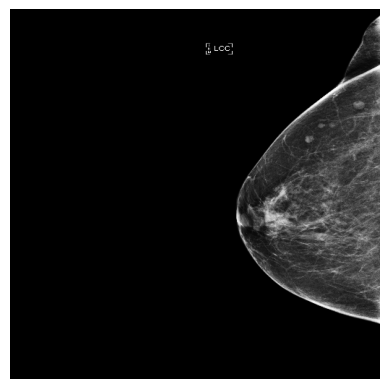

Predicted Probability: [0.6221049]


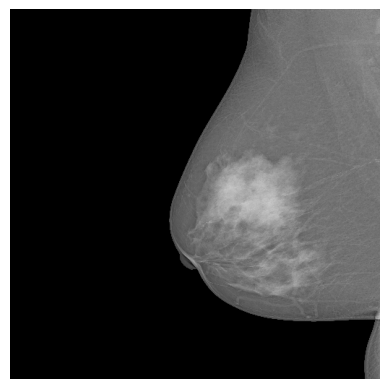

Predicted Probability: [0.5806877]


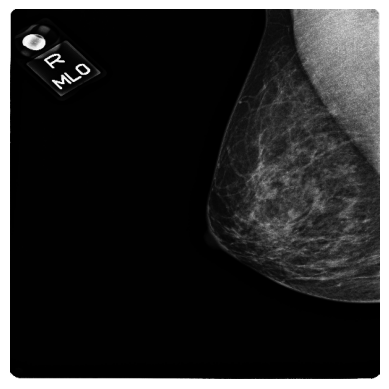

Predicted Probability: [0.601337]


In [36]:
# Optionally, visualize the selected cases
for idx in selected_false_positives:
    image_path = test_generator.filenames[idx]  # Get the image path from the generator
    visualize_data(image_path)
    print("Predicted Probability:", test_pred1[idx])

# Model explanability

In [37]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


In [38]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


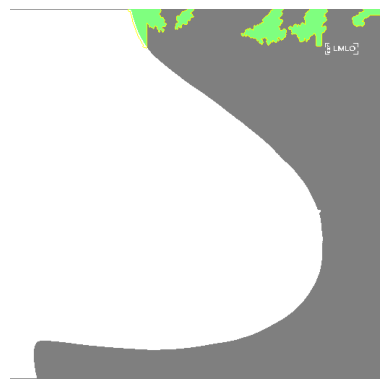

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


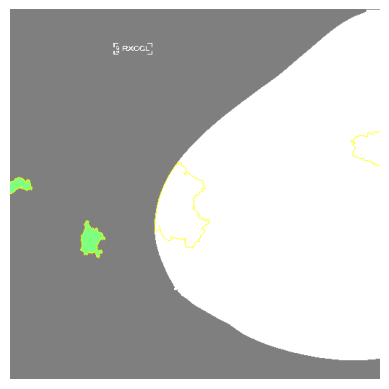

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


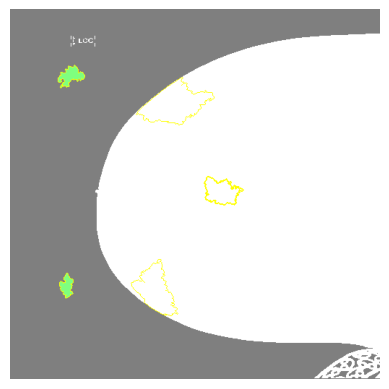

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


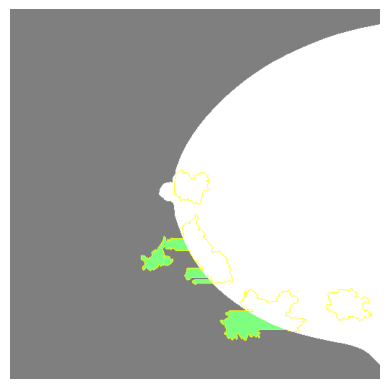

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


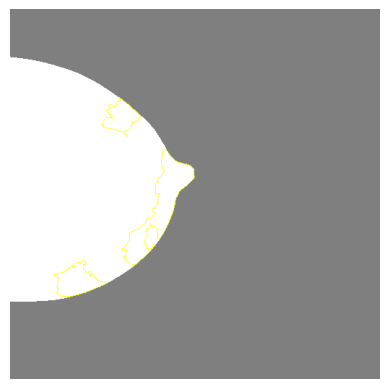

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


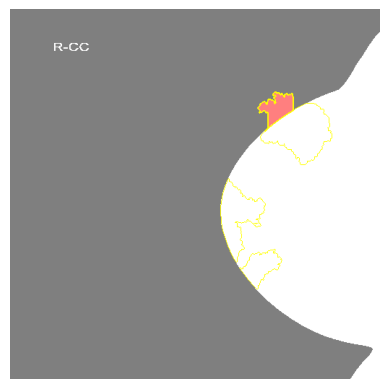

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


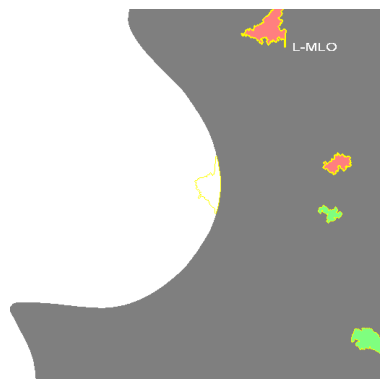

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


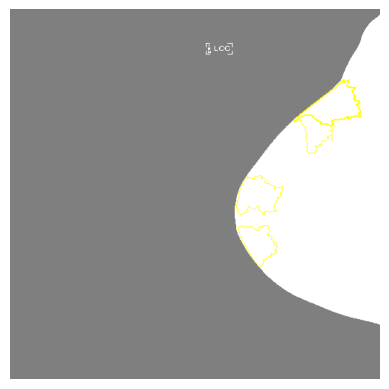

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


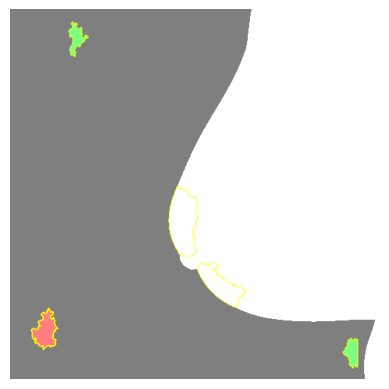

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


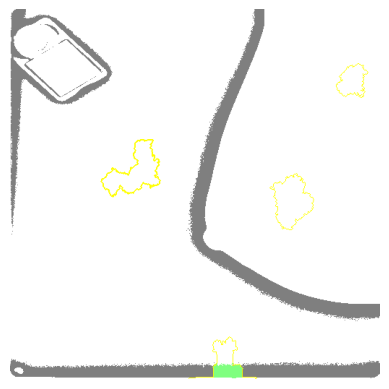

In [39]:
# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Define function to predict with your model
def predict_fn(images):
    # Preprocess images if necessary (resize, normalize, etc.)
    # Make predictions using your model
    predictions = best_model.predict(images)
    return predictions

# Iterate through false positive cases
for idx in selected_false_positives:
    image_path = test_generator.filepaths[idx]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Explain the prediction
    explanation = explainer.explain_instance(image, predict_fn, top_labels=1, hide_color=0, num_samples=1000)

    # Get the image mask and show the explanation
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.axis('off')
    plt.show()

## GradCam

In [40]:
from keras.models import Model
import tensorflow as tf

# Define function to get the last convolutional layer
def get_last_conv_layer(model):
    # Find the last convolutional layer in the model
    for layer in reversed(model.layers):
        if 'conv' in layer.name:
            return layer.name
    return None

In [41]:
last_conv_layer = get_last_conv_layer(best_model)
last_conv_layer

'conv5_block3_out'

In [42]:
# Create a new model that outputs the activations of the last convolutional layer
grad_model = Model(inputs=best_model.inputs, outputs=[best_model.get_layer(last_conv_layer).output, best_model.output])

In [43]:
# Step 3: Prepare the input image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (299, 299))  # Resize to 299x299 (InceptionV3 input size)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize pixel values
    return img

In [44]:
# Step 4: Compute the gradients and activations
def compute_heatmap(image):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, tf.argmax(predictions[0])]

    # Get the gradients of the predicted class with respect to the activations of the last conv layer
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute the heatmap
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

In [45]:
# Step 5: Overlay heatmap on the original image
def overlay_heatmap(image, heatmap, alpha=0.5):
    # Resize heatmap to match the image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert heatmap to RGB
    heatmap_rgb = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Convert heatmap to float32
    heatmap_float = heatmap_rgb.astype(np.float32) / 255.0

    # Blend heatmap with the original image
    overlayed_img = cv2.addWeighted(heatmap_float, alpha, image, 1 - alpha, 0, dtype=cv2.CV_32F)

    # Convert overlayed image to uint8
    overlayed_img_uint8 = np.uint8(overlayed_img * 255)

    return overlayed_img_uint8

/var/folders/l1/drp5zdgd1cb8tf8xkmzh4zrh0000gn/T/ipykernel_70479/770410685.py:7: RuntimeWarning: invalid value encountered in cast
  heatmap_rgb = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)


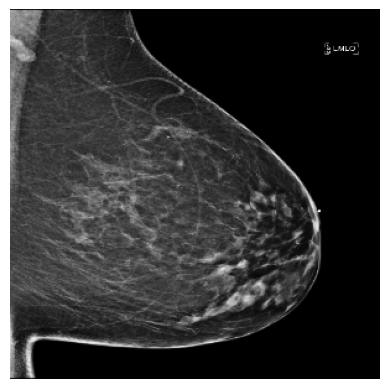

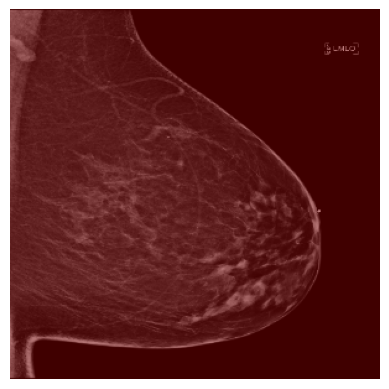

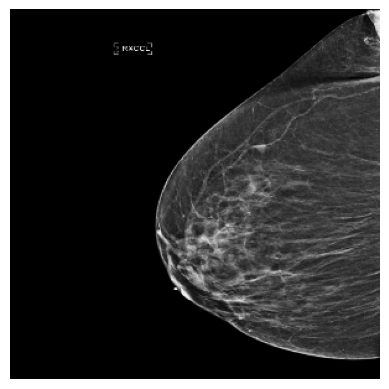

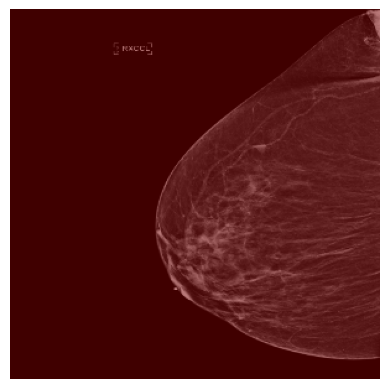

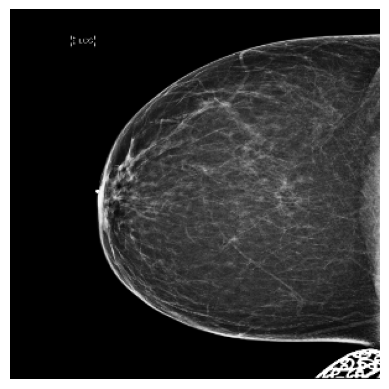

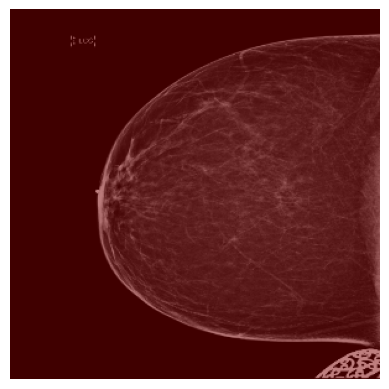

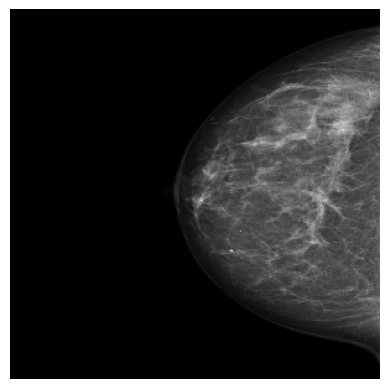

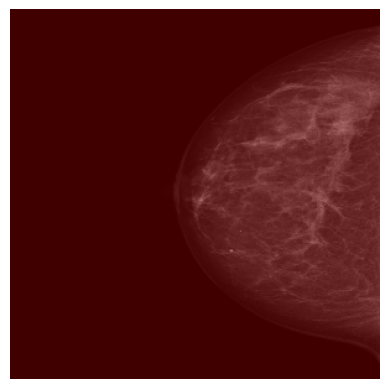

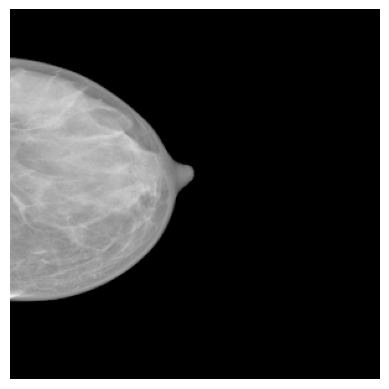

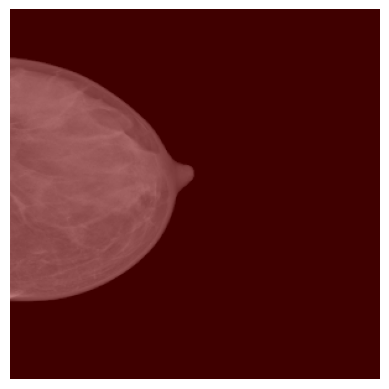

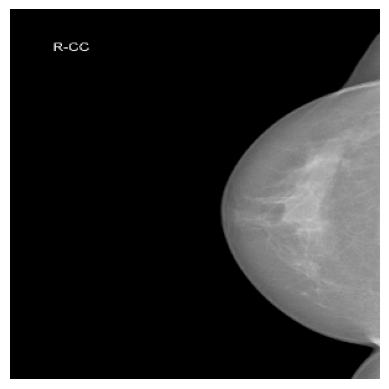

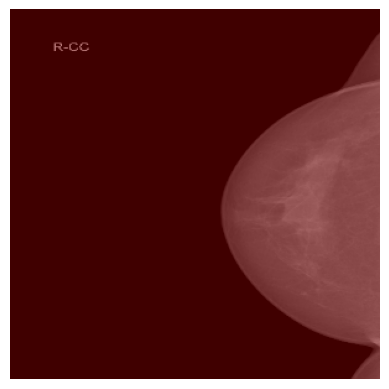

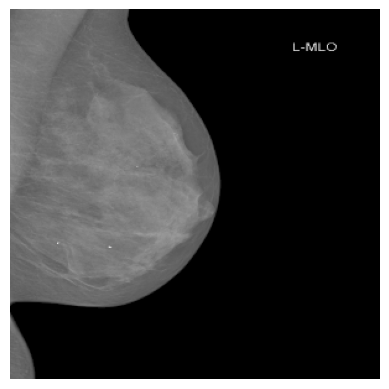

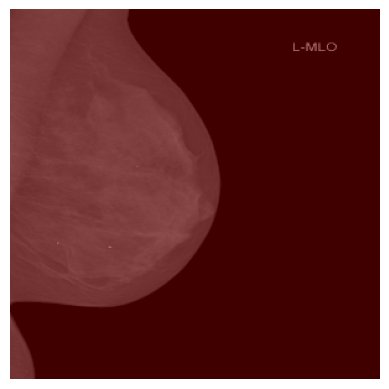

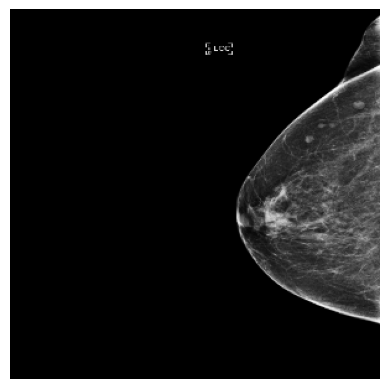

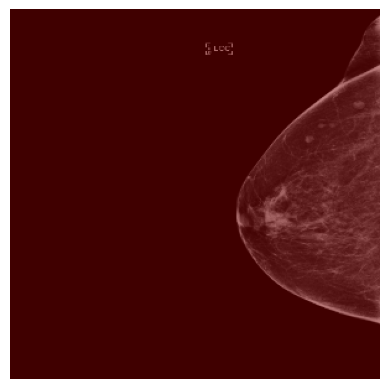

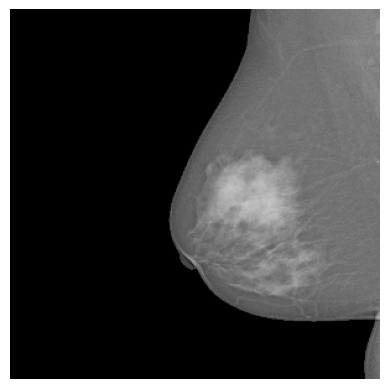

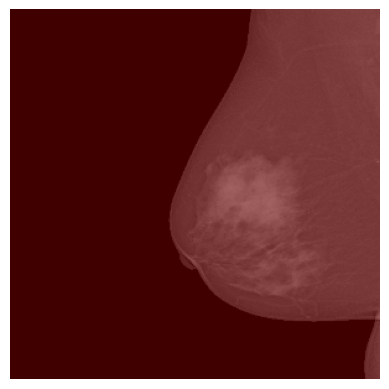

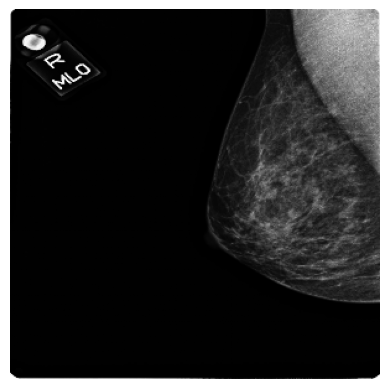

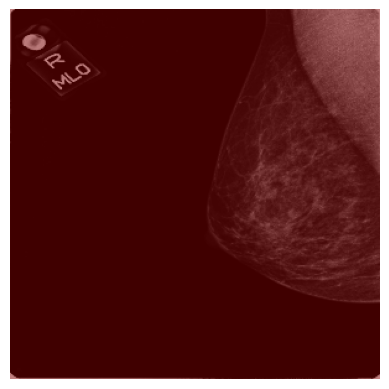

In [46]:
for idx in selected_false_positives:
    # Get the image path using the index
    image_path = test_generator.filepaths[idx]

    # Preprocess the image
    input_image = preprocess_image(image_path)

    # Compute the heatmap
    heatmap = compute_heatmap(input_image)

    # Overlay the heatmap on the original image
    overlayed_image = overlay_heatmap(input_image[0], heatmap[0])

    # Display the original image and the overlayed image
    plt.imshow(input_image[0])
    plt.axis('off')
    plt.show()

    plt.imshow(overlayed_image)
    plt.axis('off')
    plt.show()